### Голубинов Владислав Андреевич 18-АС (18-ИВТ-1)
3 Вариант

In [26]:
!pip install -U keras-tuner

Requirement already up-to-date: keras-tuner in /usr/local/lib/python3.6/dist-packages (1.0.1)


In [27]:
import keras
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from keras.layers import Dropout
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.callbacks import Callback
from keras.models import Sequential
from kerastuner.tuners import Hyperband
import IPython

In [28]:
train_path = "/content/drive/My Drive/colab data/train.csv"

In [29]:
data = pd.read_csv(train_path)
data.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,...,cafe_sum_3000_min_price_avg,cafe_sum_3000_max_price_avg,cafe_avg_price_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Bibirevo,6.407578e+06,155572,0.189727,0.000070,9576,5001.0,5,10309,11065.0,5,0,240.0,1,0,7,3,no,0,16,1,no,no,no,no,no,no,no,...,639.68,1079.37,859.52,5,21,22,16,3,1,0,2,4,0,0,21,1,13.09,13.31,29,807385,52,4036616,152,708.57,1185.71,947.14,12,39,48,40,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Nagatinskij Zaton,9.589337e+06,115352,0.372602,0.049637,6880,3119.0,5,7759,6237.0,8,0,229.0,1,0,6,1,yes,1,3,0,no,no,no,no,no,no,no,...,631.03,1086.21,858.62,1,11,11,4,2,1,0,1,7,0,6,19,1,10.26,27.47,66,2690465,40,2034942,177,673.81,1148.81,911.31,9,49,65,36,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Tekstil'shhiki,4.808270e+06,101708,0.112560,0.118537,5879,1463.0,4,6207,5580.0,7,0,1183.0,1,0,5,1,no,0,0,1,no,no,no,yes,no,no,no,...,697.44,1192.31,944.87,2,9,17,9,3,1,0,0,11,0,0,20,6,13.69,21.58,43,1478160,35,1572990,122,702.68,1196.43,949.55,10,29,45,25,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Mitino,1.258354e+07,178473,0.194703,0.069753,13087,6839.0,9,13670,17063.0,10,0,NaN,1,0,17,6,no,0,11,4,no,no,no,no,no,no,no,...,718.75,1218.75,968.75,0,5,14,10,3,0,0,1,2,0,0,18,3,14.18,3.89,8,244166,22,942180,61,931.58,1552.63,1242.11,4,7,21,15,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Basmannoe,8.398461e+06,108171,0.015234,0.037316,5706,3240.0,7,6748,7770.0,9,0,562.0,4,2,25,2,no,0,10,93,no,no,no,yes,yes,no,no,...,853.03,1410.45,1131.74,63,266,267,262,149,57,4,70,121,1,40,77,5,8.38,10.92,689,8404624,114,3503058,2283,853.88,1411.45,1132.66,143,566,578,552,319,108,17,135,236,2,91,195,14,16331452


## Подготовка данных

In [30]:
del data['id']
del data['timestamp']

In [31]:
data.head()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,...,cafe_sum_3000_min_price_avg,cafe_sum_3000_max_price_avg,cafe_avg_price_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Bibirevo,6.407578e+06,155572,0.189727,0.000070,9576,5001.0,5,10309,11065.0,5,0,240.0,1,0,7,3,no,0,16,1,no,no,no,no,no,no,no,no,86206,...,639.68,1079.37,859.52,5,21,22,16,3,1,0,2,4,0,0,21,1,13.09,13.31,29,807385,52,4036616,152,708.57,1185.71,947.14,12,39,48,40,9,4,0,13,22,1,0,52,4,5850000
1,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Nagatinskij Zaton,9.589337e+06,115352,0.372602,0.049637,6880,3119.0,5,7759,6237.0,8,0,229.0,1,0,6,1,yes,1,3,0,no,no,no,no,no,no,no,no,76284,...,631.03,1086.21,858.62,1,11,11,4,2,1,0,1,7,0,6,19,1,10.26,27.47,66,2690465,40,2034942,177,673.81,1148.81,911.31,9,49,65,36,15,3,0,15,29,1,10,66,14,6000000
2,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Tekstil'shhiki,4.808270e+06,101708,0.112560,0.118537,5879,1463.0,4,6207,5580.0,7,0,1183.0,1,0,5,1,no,0,0,1,no,no,no,yes,no,no,no,no,101982,...,697.44,1192.31,944.87,2,9,17,9,3,1,0,0,11,0,0,20,6,13.69,21.58,43,1478160,35,1572990,122,702.68,1196.43,949.55,10,29,45,25,10,3,0,11,27,0,4,67,10,5700000
3,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Mitino,1.258354e+07,178473,0.194703,0.069753,13087,6839.0,9,13670,17063.0,10,0,NaN,1,0,17,6,no,0,11,4,no,no,no,no,no,no,no,no,21155,...,718.75,1218.75,968.75,0,5,14,10,3,0,0,1,2,0,0,18,3,14.18,3.89,8,244166,22,942180,61,931.58,1552.63,1242.11,4,7,21,15,11,2,1,4,4,0,0,26,3,13100000
4,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Basmannoe,8.398461e+06,108171,0.015234,0.037316,5706,3240.0,7,6748,7770.0,9,0,562.0,4,2,25,2,no,0,10,93,no,no,no,yes,yes,no,no,no,28179,...,853.03,1410.45,1131.74,63,266,267,262,149,57,4,70,121,1,40,77,5,8.38,10.92,689,8404624,114,3503058,2283,853.88,1411.45,1132.66,143,566,578,552,319,108,17,135,236,2,91,195,14,16331452


In [32]:
data[data.columns] = SimpleImputer(strategy="most_frequent").fit_transform(data[data.columns])

In [33]:
data.head()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,...,cafe_sum_3000_min_price_avg,cafe_sum_3000_max_price_avg,cafe_avg_price_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,43,27.0,4.0,17.0,1.0,2014.0,2.0,1.0,2.0,Investment,Bibirevo,6.407578e+06,155572,0.189727,0.000070,9576,5001.0,5,10309,11065.0,5,0,240.0,1,0,7,3,no,0,16,1,no,no,no,no,no,no,no,no,86206,...,639.68,1079.37,859.52,5,21,22,16,3,1,0,2,4,0,0,21,1,13.09,13.31,29,807385,52,4036616,152,708.57,1185.71,947.14,12,39,48,40,9,4,0,13,22,1,0,52,4,5850000
1,34,19.0,3.0,17.0,1.0,2014.0,2.0,1.0,2.0,Investment,Nagatinskij Zaton,9.589337e+06,115352,0.372602,0.049637,6880,3119.0,5,7759,6237.0,8,0,229.0,1,0,6,1,yes,1,3,0,no,no,no,no,no,no,no,no,76284,...,631.03,1086.21,858.62,1,11,11,4,2,1,0,1,7,0,6,19,1,10.26,27.47,66,2690465,40,2034942,177,673.81,1148.81,911.31,9,49,65,36,15,3,0,15,29,1,10,66,14,6000000
2,43,29.0,2.0,17.0,1.0,2014.0,2.0,1.0,2.0,Investment,Tekstil'shhiki,4.808270e+06,101708,0.112560,0.118537,5879,1463.0,4,6207,5580.0,7,0,1183.0,1,0,5,1,no,0,0,1,no,no,no,yes,no,no,no,no,101982,...,697.44,1192.31,944.87,2,9,17,9,3,1,0,0,11,0,0,20,6,13.69,21.58,43,1478160,35,1572990,122,702.68,1196.43,949.55,10,29,45,25,10,3,0,11,27,0,4,67,10,5700000
3,89,50.0,9.0,17.0,1.0,2014.0,2.0,1.0,2.0,Investment,Mitino,1.258354e+07,178473,0.194703,0.069753,13087,6839.0,9,13670,17063.0,10,0,540.0,1,0,17,6,no,0,11,4,no,no,no,no,no,no,no,no,21155,...,718.75,1218.75,968.75,0,5,14,10,3,0,0,1,2,0,0,18,3,14.18,3.89,8,244166,22,942180,61,931.58,1552.63,1242.11,4,7,21,15,11,2,1,4,4,0,0,26,3,13100000
4,77,77.0,4.0,17.0,1.0,2014.0,2.0,1.0,2.0,Investment,Basmannoe,8.398461e+06,108171,0.015234,0.037316,5706,3240.0,7,6748,7770.0,9,0,562.0,4,2,25,2,no,0,10,93,no,no,no,yes,yes,no,no,no,28179,...,853.03,1410.45,1131.74,63,266,267,262,149,57,4,70,121,1,40,77,5,8.38,10.92,689,8404624,114,3503058,2283,853.88,1411.45,1132.66,143,566,578,552,319,108,17,135,236,2,91,195,14,16331452


In [34]:
#OneHotEncoder().fit_transform(data.select_dtypes(include=[object]))

In [35]:
col = data.select_dtypes(include=[object])
data.loc[:, col.columns] = col.apply(LabelEncoder().fit_transform)

In [36]:
data.head()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,...,cafe_sum_3000_min_price_avg,cafe_sum_3000_max_price_avg,cafe_avg_price_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,43,27.0,4.0,17.0,1.0,2014.0,2.0,1.0,2.0,0,9,6.407578e+06,155572,0.189727,0.000070,9576,5001.0,5,10309,11065.0,5,0,240.0,1,0,7,3,0,0,16,1,0,0,0,0,0,0,0,0,86206,...,639.68,1079.37,859.52,5,21,22,16,3,1,0,2,4,0,0,21,1,13.09,13.31,29,807385,52,4036616,152,708.57,1185.71,947.14,12,39,48,40,9,4,0,13,22,1,0,52,4,5850000
1,34,19.0,3.0,17.0,1.0,2014.0,2.0,1.0,2.0,0,70,9.589337e+06,115352,0.372602,0.049637,6880,3119.0,5,7759,6237.0,8,0,229.0,1,0,6,1,1,1,3,0,0,0,0,0,0,0,0,0,76284,...,631.03,1086.21,858.62,1,11,11,4,2,1,0,1,7,0,6,19,1,10.26,27.47,66,2690465,40,2034942,177,673.81,1148.81,911.31,9,49,65,36,15,3,0,15,29,1,10,66,14,6000000
2,43,29.0,2.0,17.0,1.0,2014.0,2.0,1.0,2.0,0,129,4.808270e+06,101708,0.112560,0.118537,5879,1463.0,4,6207,5580.0,7,0,1183.0,1,0,5,1,0,0,0,1,0,0,0,1,0,0,0,0,101982,...,697.44,1192.31,944.87,2,9,17,9,3,1,0,0,11,0,0,20,6,13.69,21.58,43,1478160,35,1572990,122,702.68,1196.43,949.55,10,29,45,25,10,3,0,11,27,0,4,67,10,5700000
3,89,50.0,9.0,17.0,1.0,2014.0,2.0,1.0,2.0,0,65,1.258354e+07,178473,0.194703,0.069753,13087,6839.0,9,13670,17063.0,10,0,540.0,1,0,17,6,0,0,11,4,0,0,0,0,0,0,0,0,21155,...,718.75,1218.75,968.75,0,5,14,10,3,0,0,1,2,0,0,18,3,14.18,3.89,8,244166,22,942180,61,931.58,1552.63,1242.11,4,7,21,15,11,2,1,4,4,0,0,26,3,13100000
4,77,77.0,4.0,17.0,1.0,2014.0,2.0,1.0,2.0,0,6,8.398461e+06,108171,0.015234,0.037316,5706,3240.0,7,6748,7770.0,9,0,562.0,4,2,25,2,0,0,10,93,0,0,0,1,1,0,0,0,28179,...,853.03,1410.45,1131.74,63,266,267,262,149,57,4,70,121,1,40,77,5,8.38,10.92,689,8404624,114,3503058,2283,853.88,1411.45,1132.66,143,566,578,552,319,108,17,135,236,2,91,195,14,16331452


In [37]:
data_norm = (data - data.mean()) / data.std()

In [38]:
# data_norm = data

In [39]:
data_norm

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,...,cafe_sum_3000_min_price_avg,cafe_sum_3000_max_price_avg,cafe_avg_price_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,-0.294868,-0.089038,-0.685629,0.510793,-0.441364,-0.005079,0.087540,-0.157297,-0.090295,-0.752845,-1.719242,-0.544779,1.235770,-0.166744,-1.000959,1.162277,0.985210,0.312276,1.241899,0.773692,0.085620,-0.329039,-0.771420,-0.214947,-0.311619,0.055534,0.031491,-0.259894,-0.189827,2.488294,-0.308173,-0.239572,-0.286803,-0.099041,-0.744731,-0.196784,-0.319471,-0.170724,-0.333139,-0.212349,...,-0.596907,-0.554649,-0.583096,-0.124689,-0.094423,-0.121537,-0.150800,-0.249990,-0.215968,-0.254776,-0.267468,-0.321423,-0.444546,-0.293920,0.040368,-0.581079,-0.863593,0.527170,-0.272666,-0.257776,0.914065,2.849041,-0.220641,-0.365321,-0.388263,-0.379643,-0.174544,-0.215950,-0.201656,-0.189155,-0.313865,-0.238989,-0.326969,-0.070249,-0.174274,0.915161,-0.420238,-0.017208,-0.406419,-0.266319
1,-0.531514,-0.259583,-0.873719,0.510793,-0.441364,-0.005079,0.087540,-0.157297,-0.090295,-0.752845,-0.165287,-0.390696,0.540779,0.877718,-0.583331,0.455893,0.020533,0.312276,0.602744,-0.493398,0.956420,-0.329039,-0.784631,-0.214947,-0.311619,-0.096627,-0.576401,3.847593,0.472210,-0.253274,-0.350659,-0.239572,-0.286803,-0.099041,-0.744731,-0.196784,-0.319471,-0.170724,-0.333139,-0.247406,...,-0.635486,-0.535169,-0.586271,-0.343958,-0.233647,-0.279745,-0.320159,-0.274214,-0.215968,-0.254776,-0.332346,-0.205078,-0.444546,0.161013,-0.065767,-0.581079,-1.116081,3.029108,-0.034480,0.559869,0.412478,0.856949,-0.172054,-0.594007,-0.545044,-0.564826,-0.264717,-0.136543,-0.066914,-0.221393,-0.232195,-0.274218,-0.326969,-0.001564,-0.026432,0.915161,0.065653,0.285216,1.638898,-0.234939
2,-0.294868,-0.046402,-1.061810,0.510793,-0.441364,-0.005079,0.087540,-0.157297,-0.090295,-0.752845,1.337718,-0.622229,0.305014,-0.607473,-0.002813,0.193620,-0.828301,-0.021749,0.213736,-0.665825,0.666154,-0.329039,0.361084,-0.214947,-0.311619,-0.248788,-0.576401,-0.259894,-0.189827,-0.885944,-0.308173,-0.239572,-0.286803,-0.099041,1.342722,-0.196784,-0.319471,-0.170724,-0.333139,-0.156609,...,-0.339294,-0.232995,-0.281974,-0.289141,-0.261492,-0.193450,-0.249593,-0.249990,-0.215968,-0.254776,-0.397223,-0.049950,-0.444546,-0.293920,-0.012700,1.620072,-0.810062,1.988401,-0.182541,0.033478,0.203483,0.397208,-0.278946,-0.404072,-0.342715,-0.367187,-0.234659,-0.295356,-0.225434,-0.310048,-0.300254,-0.274218,-0.326969,-0.138933,-0.068673,-0.726150,-0.225882,0.306818,0.820771,-0.297699
3,0.914656,0.401279,0.254825,0.510793,-0.441364,-0.005079,0.087540,-0

In [40]:
split = 0.7
seed = 200

In [41]:
y_data = data_norm.get('price_doc')
x_data = data_norm.drop('price_doc' , axis=1)

In [42]:
x_train = x_data.sample(frac=split, random_state=seed)
x_test = x_data.drop(x_train.index)

y_train = y_data.sample(frac=split, random_state=seed)
y_test = y_data.drop(y_train.index)

In [43]:
x_train

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,...,cafe_count_3000,cafe_sum_3000_min_price_avg,cafe_sum_3000_max_price_avg,cafe_avg_price_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000
8974,-0.268574,-0.089038,0.066734,0.510793,-0.441364,-0.005079,0.087540,-0.157297,-0.090295,-0.752845,0.853699,-0.546217,0.309749,-1.148360,1.811650,0.070212,0.608463,0.646300,0.303218,0.060626,0.375887,-0.329039,-0.411132,-0.884783,-0.311619,0.055534,0.031491,-0.259894,-0.189827,-0.885944,-0.308173,-0.239572,-0.286803,-0.099041,-0.744731,-0.196784,-0.319471,-0.170724,-0.333139,-0.222373,...,-0.216678,-0.413287,-0.356514,-0.387746,-0.343958,-0.177957,-0.207832,-0.221366,-0.225767,-0.215968,-0.254776,-0.332346,-0.166296,-0.444546,0.009369,0.464909,1.179842,-0.557574,1.103181,-0.285540,-0.251294,0.078086,-0.167312,-0.300324,-0.521967,-0.489427,-0.502702,-0.354891,-0.303297,-0.257137,-0.301988,-0.327477,-0.309447,-0.326969,-0.276302,-0.089793,-0.726150,0.114242,0.263614,1.843430
29577,0.783186,-0.259583,-0.497538,-2.340039,-0.441364,-0.005079,1.502618,-0.199773,-0.090295,1.328252,0.649902,2.378515,-1.287399,0.669681,-0.393586,-1.174867,-0.350576,-1.357845,-1.184385,-0.194209,-1.365715,-0.329039,-0.411132,-0.884783,-0.311619,-0.857432,-0.880347,-0.259894,-0.189827,-0.885944,-0.308173,-0.239572,-0.286803,-0.099041,-0.744731,-0.196784,3.130070,-0.170724,-0.333139,-0.467860,...,-0.378672,1.010137,0.643308,0.794549,-0.398775,-0.386794,-0.437953,-0.362498,-0.322661,-0.275194,-0.254776,-0.397223,-0.398987,-0.444546,-0.293920,-1.074053,-1.021309,0.727168,0.216195,-0.427164,-0.514537,-1.050485,-0.697441,-0.475238,0.204880,0.137784,0.164278,-0.535239,-0.454169,-0.550398,-0.479298,-0.409148,-0.309447,-0.326969,-0.448013,-0.448837,-0.726150,-0.420238,-0.989284,-0.815482
2755,-0.268574,-0.025083,-1.249901,0.510793,-0.441364,-0.005079,0.087540,-0.157297,-0.090295,-0.752845,0.114934,-0.249462,-0.391566,1.055052,-0.581425,-0.520100,-1.004116,0.312276,-0.403111,-0.728549,0.085620,-0.329039,-0.969578,1.124725,-0.311619,0.207695,0.639383,3.847593,2.458319,-0.675054,0.031718,-0.239572,-0.286803,-0.099041,-0.744731,-0.196784,-0.319471,-0.170724,-0.333139,-0.283841,...,-0.002984,-0.209195,-0.127477,-0.165160,-0.343958,0.156181,0.007906,-0.136687,0.161811,-0.156742,-0.254776,-0.137713,-0.011168,-0.444546,0.009369,0.624112,-0.140849,0.254311,0.887619,0.499827,0.665592,0.454277,0.598975,0.329366,-0.168544,-0.151561,-0.158384,0.276326,0.514588,0.432421,0.149346,0.325890,-0.098073,0.226658,0.307516,0.670536,2.556473,0.211420,1.192487,0.411708
1855,-0.505220,-0.259583,0.819097,0.510793,-0.441364,-0.005079,0.087540,-

In [44]:
y_train

8974    -1.280940
29577   -0.026341
2755    -0.130339
1855    -0.967140
9680    -0.428508
           ...   
489      0.706462
2533    -0.172179
5454    -0.214019
19491    0.049205
23781   -0.248604
Name: price_doc, Length: 21330, dtype: float64

In [45]:
def build_model(hp):
  activation_choice = hp.Choice('activation', values=['relu', 'sigmoid', 'tanh', 'elu', 'selu'])
  hidden_layers_choice = hp.Choice('hidden_layers', values=[0, 1, 2])

  model = Sequential()
  model.add(Dense(289, activation="relu", input_shape=(x_train.shape[1],)))
  model.add(
      Dense(
          units=hp.Int(
              'input_units',
              min_value=128, 
              max_value=256, 
              step=16,
          ), 
          input_dim=x_train.shape[1], 
          activation=activation_choice,
      ),
  )
  model.add(Dropout(0.25))
  for i in range(hidden_layers_choice):
    model.add(
        Dense(
            units=hp.Int(
                f'layer_{i + 1}_units',
                min_value=2 // (i + 1),
                max_value=128 // (i + 1),
                step=14 // (i + 1),
            ),
            activation=activation_choice
        )
    )
  model.add(Dense(1))

  model.compile(
      optimizer='adam', 
      loss='mae',
      metrics=['mae'], 
  )

  return model

In [46]:
tuner = Hyperband(
    build_model,
    objective='mae', 
    max_epochs=10,
    directory='models',
    project_name='lab1',
)

In [47]:
tuner.search_space_summary()

In [48]:
class ClearTrainingOutput(Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [49]:
tuner.search(
    x_train,
    y_train,
    validation_split=0.2,
    verbose=2,
    callbacks = [ClearTrainingOutput()],
)

INFO:tensorflow:Oracle triggered exit


In [50]:
best_hps = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 289)               83810     
_________________________________________________________________
dense_1 (Dense)              (None, 208)               60320     
_________________________________________________________________
dropout (Dropout)            (None, 208)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20900     
_________________________________________________________________
dense_3 (Dense)              (None, 57)                5757      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 58        
Total params: 170,845
Trainable params: 170,845
Non-trainable params: 0
__________________________________________________

In [51]:
fit_history = model.fit(x_train, y_train, epochs=15, batch_size=64, validation_split=0.2, verbose=2)

Epoch 1/15
267/267 - 1s - loss: 0.4381 - mae: 0.4381 - val_loss: 0.3612 - val_mae: 0.3612
Epoch 2/15
267/267 - 1s - loss: 0.3616 - mae: 0.3616 - val_loss: 0.3292 - val_mae: 0.3292
Epoch 3/15
267/267 - 1s - loss: 0.3287 - mae: 0.3287 - val_loss: 0.3220 - val_mae: 0.3220
Epoch 4/15
267/267 - 1s - loss: 0.3232 - mae: 0.3232 - val_loss: 0.3184 - val_mae: 0.3184
Epoch 5/15
267/267 - 1s - loss: 0.3145 - mae: 0.3145 - val_loss: 0.3102 - val_mae: 0.3102
Epoch 6/15
267/267 - 1s - loss: 0.3016 - mae: 0.3016 - val_loss: 0.3090 - val_mae: 0.3090
Epoch 7/15
267/267 - 1s - loss: 0.2985 - mae: 0.2985 - val_loss: 0.3031 - val_mae: 0.3031
Epoch 8/15
267/267 - 1s - loss: 0.2921 - mae: 0.2921 - val_loss: 0.2989 - val_mae: 0.2989
Epoch 9/15
267/267 - 1s - loss: 0.2916 - mae: 0.2916 - val_loss: 0.3167 - val_mae: 0.3167
Epoch 10/15
267/267 - 1s - loss: 0.2860 - mae: 0.2860 - val_loss: 0.2990 - val_mae: 0.2990
Epoch 11/15
267/267 - 1s - loss: 0.2849 - mae: 0.2849 - val_loss: 0.3061 - val_mae: 0.3061
Epoch 12

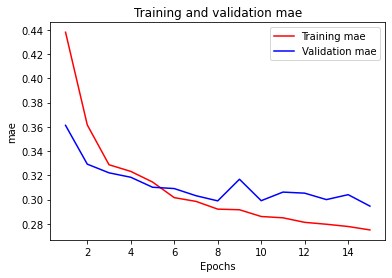

In [52]:
history = fit_history.history
epochs = range(1, len(history['loss']) + 1)
mae = history['mae']
val_mae = history['val_mae']
plt.plot(epochs, mae, 'r', label='Training mae')
plt.plot(epochs, val_mae, 'b', label='Validation mae')
plt.title('Training and validation mae')
plt.xlabel('Epochs')
plt.ylabel('mae')
plt.legend()
plt.show()

In [53]:
results = model.evaluate(x_test, y_test, verbose=0)
print('test loss, test acc:', results)

test loss, test acc: [0.300481915473938, 0.300481915473938]


In [54]:
pred = model.predict(x_test)

In [55]:
pred

array([[ 1.0184606 ],
       [ 0.55966187],
       [ 0.28695247],
       ...,
       [-0.24329308],
       [ 0.5138313 ],
       [ 0.45090264]], dtype=float32)

In [56]:
print('размерность прогнозов:', pred.shape)

размерность прогнозов: (9141, 1)


In [57]:
print('размерность y:', y_test.shape)

размерность y: (9141,)


In [58]:
pred_1 = pred
pred_1.shape = (9141,)

In [59]:
np.corrcoef(pred_1, y_test)

array([[1.        , 0.80101714],
       [0.80101714, 1.        ]])

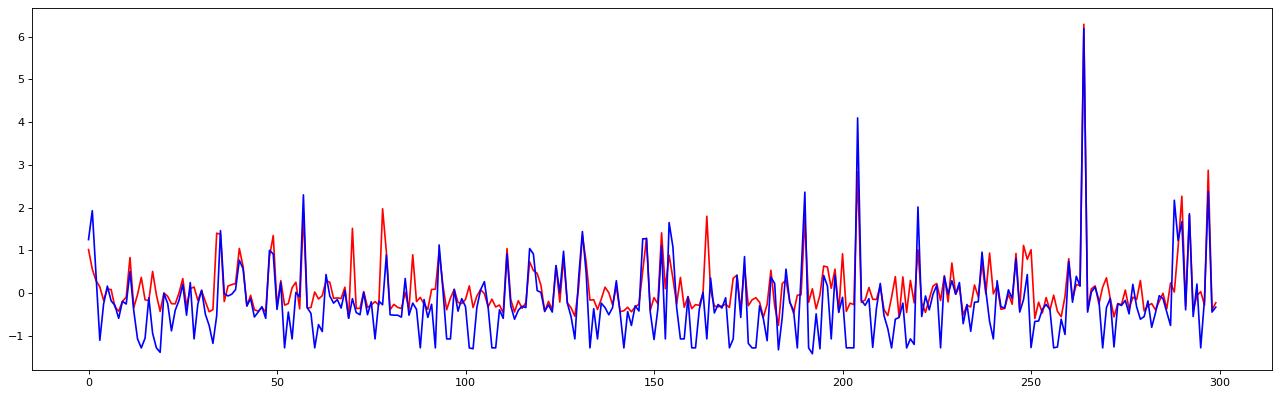

In [60]:
from matplotlib.pyplot import figure
size = 300
figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(np.arange(size), pred_1[:size], color='r')
plt.plot(np.arange(size), y_test[:size], color='b')
plt.show()

In [61]:
model.save(f'/content/drive/My Drive/Colab models/lab1/lab1_{mae}.h5')

OSError: ignored